In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp
from sklearn.svm import SVR

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Validation



### Load Trained Model

In [15]:
import joblib

# Load
# TODO: This is similar to in FilenameVersioner maybe move it there
import glob
import os
def find_latest(f_glob, base_dir):
    versions = glob.glob(f'{base_dir}/{f_glob}')
    # early return
    if len(versions) < 1:
        return None

    return max(versions, key=os.path.getctime)

from filename_versioner import FilenameVersioner
tng_data_dir = './data/model'
model_file = find_latest('svr_rbf*', tng_data_dir)
# rms_file = find_latest('rms_trn*', tng_data_dir)
print(model_file)
# print(rms_file)

./data/model/svr_rbf.x1y4.0.joblib


In [16]:
fv = FilenameVersioner((model_file, 'joblib'), base_dir=tng_data_dir )
xy_version, tng_version = model_file.split('.')[-3:-1]
print(xy_version)
print(tng_version)

# Load Trained Model
# tng_data_dir = './data/model'
# svr_file = f'{tng_data_dir}/svr_trained.joblib'

model = joblib.load(model_file)

# Load Training data (for comparison)
# rms_file = f'./data/model/rms_trn.joblib'
# (x_rms, y_rms) = joblib.load(rms_file)
# ap_trn_file =  f'./data/model/ap_trn.joblib'
# ap_trn = joblib.load(ap_trn_file)

x1y4
0


In [21]:
from audio_plexer import AudioPlexer
from kss_chunk import KssChunk
from marker_df  import MarkerDf

kss_id = "1_0005"
# tg_dir = 'data/korean-single-speaker/kss'
#
# chunk_dir = 'data/korean-single-speaker/kss_chunks'
#
# markers_char = MarkerDf.read_csv(f'{chunk_dir}/chunk_char.csv')
# markers_syl = MarkerDf.read_csv(f'{chunk_dir}/chunk_syl.csv')

markers_char_df, markers_syl_df = KssChunk.load_all()
markers_char = MarkerDf(markers_char_df)
markers_syl = MarkerDf(markers_syl_df)

print(markers_syl.df)

    syl    start     stop                                        audio
0     0  0.00000  0.14298  data/korean-single-speaker/kss/1/1_0000.wav
1    그  0.14298  0.25143  data/korean-single-speaker/kss/1/1_0000.wav
2     는  0.25143  0.49473  data/korean-single-speaker/kss/1/1_0000.wav
3     0  0.49473  0.52397  data/korean-single-speaker/kss/1/1_0000.wav
4   괜  0.52397  0.71846  data/korean-single-speaker/kss/1/1_0000.wav
..  ...      ...      ...                                          ...
7   잘  0.67573  0.91961  data/korean-single-speaker/kss/1/1_0005.wav
8    아  0.91961  1.07637  data/korean-single-speaker/kss/1/1_0005.wav
9    세  1.07637  1.28889  data/korean-single-speaker/kss/1/1_0005.wav
10  요?  1.28889  1.44689  data/korean-single-speaker/kss/1/1_0005.wav
11   0   1.44689  1.68841  data/korean-single-speaker/kss/1/1_0005.wav

[95 rows x 4 columns]


In [22]:
# TODO Set up to use Audio rather that AudioPlexer
x_val_path = f'{tg_dir}/{kss_id}.wav'
x_val_paths = [x_val_path]
ap_params_val = {
                    'n_fft': 256,
                    'n_hops':  4,
                    'sliding_window_size': 128,
                    'sliding_offset': 64
                }

#TODO: We will operate on single files so we should use Audio not AudioPlexer
# AudioPlexer: n audio files -> 1 TextGrid
# Audio: n audio files -> n TextGrids
disp.obj(x_val_paths, 'validation files')
ap = AudioPlexer(x_val_paths, **ap_params_val)
disp.audio(data=ap.wav(), rate=ap.sr)

x_rms = ap.rms().flatten()
disp.obj(x_rms.shape, 'x_rms shape')

validation files

['data/korean-single-speaker/kss/1/1_0005.wav']

Audio[WARNING]: Modifying input wav from size 74459 to 74432
Audio[INFO]: change in number of samples: -27 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 1163, reduced 1162.984375


x_rms shape

(1163,)

In [23]:
# y_val
val_syl_df = markers_syl.df.loc[markers_syl.df['audio'] == x_val_path]
is_speech_wav = ap.speech_from_interval(val_syl_df, missing_val=False)
is_speech_rms = ap.to_rms(is_speech_wav.astype(float)).flatten()

from marker_df import MarkerDf
# disp.file_source('marker_df.py', label='marker_df.py ')


# y_val_path = f'{tg_dir}/{kss_id}.TextGrid'
y_rms = is_speech_rms
disp.obj(y_rms.shape, 'y_rms shape')

y_rms shape

(1163,)

## Model Prediction

In [24]:
X_val, _ = ap.sliding_window_features(x_rms, y=y_rms)

disp.obj(X_val.shape, 'X_val shape')
y_pred = model.predict(X_val)

X_val shape

(972, 128)

In [25]:
# A bit of a hack to get the offset.
# TODO: A better way is to save the AudioPlexer used for training
calc_offset = np.argmax(x_rms > 0.01) - np.argmax(y_pred > 0.8)
sw_offset = 64 # calc_offset

def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')

def delta(y1, y2, y1_offset, y2_offset):
    min_len = min(len(y1), len(y2))
    return align(y1, y1_offset)[0:min_len] - align(y2, y2_offset)[0:min_len]

def speech_base_delta(y, offset):
    return delta(y, y_rms, offset, 0)

# TODO: Move these into a class
def pred_threshold(pred_vals, thresh=0.5):
    return np.where(pred_vals > thresh, True, False)


def get_events_from_preds(preds):
    pred_pad = np.pad(preds, (0,0), 'minimum')

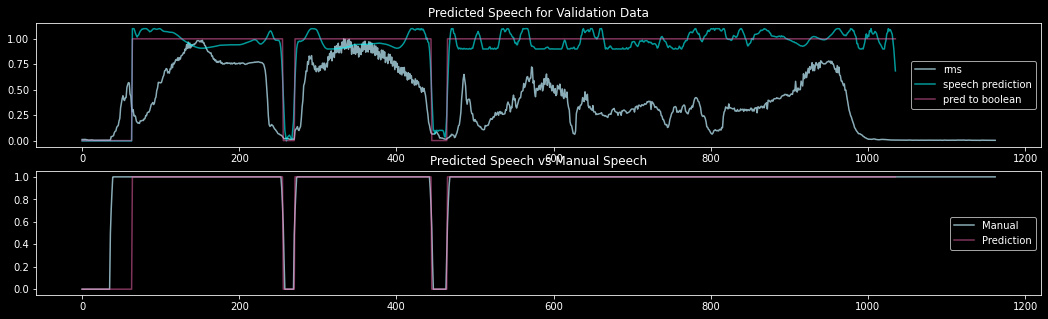

In [26]:
fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(18,5))

y_pred_bool = pred_threshold(y_pred, 0.5)
ax1.set_title(f'Predicted Speech for Validation Data')
ax1.plot(x_rms, color='lightblue', alpha=0.8, label='rms')
ax1.plot(align(y_pred, sw_offset), color='cyan', alpha=0.6, label='speech prediction')
ax1.plot(align(1*y_pred_bool, sw_offset), color='hotpink', alpha=0.5, label='pred to boolean')
ax1.legend(loc='center right')

ax2.set_title(f'Predicted Speech vs Manual Speech')
ax2.plot(y_rms, color='lightblue', alpha=0.8, label='Manual')
ax2.plot(align(1*y_pred_bool, sw_offset), color='hotpink', alpha=0.5, label='Prediction')
ax2.legend(loc='center right')
plt.show()

Testing for Vals

array([False,  True, False,  True, False])

Event Indices

array([ 64, 256, 271, 445, 465])

Event Vaues

array([False,  True, False,  True, False])

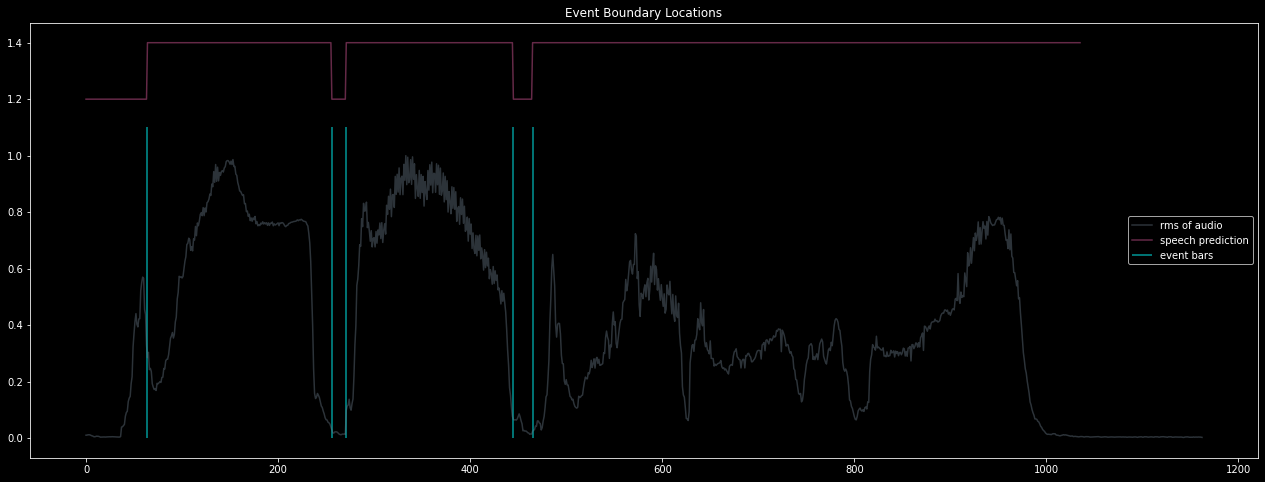

Speech Event_t

array([0.        , 0.09287982, 0.37151927, 0.39328798, 0.64580499,
       0.67482993])

In [27]:

#TODO: Figure out where to do final alignment
# y_train_pred_bool_align = align(y_train_pred_bool, sw_offset)
y_pred_bool_align = align(y_pred_bool, sw_offset)

# TODO: Move these to a class
def get_intervals(bs_in):
    bs = np.pad(bs_in, (1,1), 'edge')
    d = np.diff(bs)
    ivl_idxs = np.where(d > 0)[0]
    disp.obj(bs[ivl_idxs], 'Testing for Vals')
    return ivl_idxs, bs[ivl_idxs]

y_pred_event_idxs, y_pred_event_vals = get_intervals(y_pred_bool_align)
disp.obj(y_pred_event_idxs, "Event Indices")
disp.obj(y_pred_event_vals, "Event Vaues")


fig, axs_  = plt.subplots(1, 1, figsize=(22,8), squeeze=False)
axs = axs_[:,0]
axs[0].set_title(f'Event Boundary Locations')
axs[0].plot(x_rms, color='slategray', alpha=0.4, label='rms of audio')
axs[0].plot(align(0.2*y_pred_bool+1.2, sw_offset), color='hotpink', alpha=0.4, label='speech prediction')
axs[0].vlines(y_pred_event_idxs, 0, 1.1, color='cyan', alpha=0.6, label="event bars")
axs[0].legend(loc='center right')
# axs[0].plot(delta(1*y_svr_pred, y_base, sw_offset, 0), color='cyan', alpha=0.5, label='pred bool - base')
plt.show()


y_pred_event_t = y_pred_event_idxs  * (ap.hop_length/ap.sr)
# add start event at t=0
# TODO: add end event at t=? (maybe ok to just add end padding??)
speech_event_t = np.pad(y_pred_event_t, (1, 0), constant_values=0.0)
disp.obj(speech_event_t, "Speech Event_t")

In [28]:
tg_pred_path = f'{tg_dir}/{kss_id}.pred.{xy_version}.{tng_version}.TextGrid'

# audio_path = f'{tg_dir}/{audio_file}'
# tg = textgrid.TextGrid.fromFile(tg_path)

# TODO: This really needs to be a class as it should only be one per file.
import string
from pathlib import Path

# TODO: Combine vals into src, for tighter coupling
def make_textgrid(src, vals):
    ivl_template = string.Template(Path('./template/interval.template').read_text())
    item_template = string.Template(Path('./template/item.template').read_text())
    item_list_template = string.Template(Path('./template/itemlist.template').read_text())
    textgrid_template = string.Template(Path('./template/textgrid.template').read_text())

    item_lists_a = []
    for (item_idx, (item_name, event_t)) in enumerate(src):
        ivls_a = []
        # we're going to be taking pairs of data, so skip the last iteration
        ivls_size = len(event_t) - 1
        for i in range(ivls_size):
            ivl_dict = {
                'ivl_id': i+1,
                'ivl_xmin': event_t[i],
                'ivl_xmax': event_t[i+1],
                'ivl_text': f'{vals[i]}' if vals is not None else ' '
            }
            ivls_a.append(ivl_template.substitute(ivl_dict))

        ivls = '\n'.join(ivls_a)

        item_dict = {
            'item_name': item_name,
            'item_xmin': min(event_t),
            'item_xmax': max(event_t),
            'item__intervals_size': ivls_size,
            'item__intervals': ivls
        }
        item = item_template.substitute(item_dict)

        item_list_dict = {
            'item_list_id': item_idx+1,
            'item_list__items': item
        }
        item_lists_a.append(item_list_template.substitute(item_list_dict))

    item_lists = '\n'.join(item_lists_a)
    textgrid_dict = {
        'textgrid_xmin': min(event_t),
        'textgrid_xmax': max(event_t),
        'textgrid_size': len(item_lists_a),
        'textgrid__item_list': item_lists
    }
    return textgrid_template.substitute(textgrid_dict)

def save_textgrid(src, vals, tg_pred_path):
    with open(tg_pred_path, 'w') as f:
        print(f'saving textgrid to {tg_pred_path}')
        f.write(make_textgrid(src, vals))

tg_vals = np.where(y_pred_event_vals, ' ', '0')
textgrid_src = [('char', speech_event_t), ('syl', speech_event_t)]
print('Check to see if save is commented or not')
save_textgrid(textgrid_src, tg_vals, tg_pred_path)

Check to see if save is commented or not
saving textgrid to data/korean-single-speaker/kss/1/1_0005.pred.x1y4.0.TextGrid


In [29]:
import pandas as pd
from kss_textgrid import KssTextGrid
# TODO: Compare Predicted vs Actual TextGrid

tg_dir = 'data/korean-single-speaker/kss/1'
# tg_file = '1_0003.TextGrid'
# audio_file = '1_0003.wav'
# tg_path = f'{tg_dir}/{tg_file}'
# audio_path = f'{tg_dir}/{audio_file}'
# print(tg_path)
# tg = textgrid.TextGrid.fromFile(tg_path)
val_kss_id = '1_0005'

syls_df_pred = KssTextGrid(val_kss_id, tg_dir, path=tg_pred_path).syls_df()
disp.obj(syls_df_pred[syls_df_pred['syl'] == '0'], f'Predicted Syl DF for {val_kss_id}')

assert(val_kss_id == kss_id, f'{val_kss_id} != {kss_id}')

syls_df_actual = KssTextGrid(val_kss_id, tg_dir).syls_df()
disp.obj(syls_df_actual[syls_df_actual['syl'] == '0'], f'Actual Syl DF for {val_kss_id}')

<>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-29-112d1854b910>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(val_kss_id == kss_id, f'{val_kss_id} != {kss_id}')


Predicted Syl DF for 1_0005

,syl,start,stop,audio
0,0,0.00000,0.09288,data/korean-single-speaker/kss/1/1_0005.wav
2,0,0.37152,0.39329,data/korean-single-speaker/kss/1/1_0005.wav
4,0,0.64580,0.67483,data/korean-single-speaker/kss/1/1_0005.wav


Actual Syl DF for 1_0005

,syl,start,stop,audio
0,0,0.00000,0.05370,data/korean-single-speaker/kss/1/1_0005.wav
3,0,0.37044,0.39335,data/korean-single-speaker/kss/1/1_0005.wav
6,0,0.64463,0.67573,data/korean-single-speaker/kss/1/1_0005.wav
